# Analyze current car_init.csv

In [38]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

from pyproj import Geod
from shapely.geometry import MultiPoint
from shapely.geometry import Point, LineString, Polygon


import contextily as ctx


In [4]:
df = pd.read_csv('resources/car_init.csv', sep=';')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   startLon   500 non-null    float64
 1   startLat   500 non-null    float64
 2   destLon    500 non-null    float64
 3   destLat    500 non-null    float64
 4   driveMode  1000 non-null   int64  
 5   maxSpeed   1000 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 47.0 KB


In [ ]:
df.groupby(['startLon','startLat']).size().reset_index().rename(columns={0:'count'})

In [ ]:
df.groupby(['destLon','destLat']).size().reset_index().rename(columns={0:'count'})

In [ ]:
df.groupby(['startLon','startLat', 'destLon','destLat']).size().reset_index().rename(columns={0:'count'})

<AxesSubplot:>

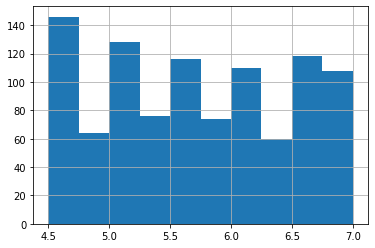

In [35]:
df['maxSpeed'].hist()

In [1]:
from shapely.geometry import Point
from shapely.geometry import MultiPoint


# lon, lat
gateways = [
    Point(31.482268, -24.979422),
    Point(31.534930, -25.460457),
    Point(31.591958, -24.994678),
    Point(31.779859, -24.389864),
    Point(31.894040, -25.362301),
    Point(31.915333, -25.115829),
]

# test points
gateways = [
    Point(31.3124044, -22.4486818),
    Point(31.0835867, -22.4402731),
    Point(31.0446678, -22.7104647),
]


In [2]:
gateways[0].wkt

'POINT (31.3124044 -22.4486818)'

In [5]:
scheduler_rows = []

for source in gateways:

    target_list = []

    for target in gateways:
        if source is not target:
            target_list.append(target)

    mp = MultiPoint(target_list)

    scheduler_rows.append({
        'startTime': '0:00',
        'endTime': '23:00',
        'spawningIntervalInMinutes': 1,
        'spawningAmount': 1,
        'source': source.wkt,
        'destination': mp.wkt
    })

scheduler_df = pd.DataFrame(scheduler_rows)
scheduler_df.to_csv('tourist_scheduler.csv', index=False)

In [6]:
scheduler_df

,startTime,endTime,spawningIntervalInMinutes,spawningAmount,source,destination
0,0:00,23:00,1,1,POINT (31.3124044 -22.4486818),"MULTIPOINT (31.0835867 -22.4402731, 31.0446678..."
1,0:00,23:00,1,1,POINT (31.0835867 -22.4402731),"MULTIPOINT (31.3124044 -22.4486818, 31.0446678..."
2,0:00,23:00,1,1,POINT (31.0446678 -22.7104647),"MULTIPOINT (31.3124044 -22.4486818, 31.0835867..."


# Use KNP provided points

Gates: https://www.sanparks.org/parks/kruger/get_there/gates.php und https://en.wikipedia.org/wiki/Kruger_National_Park#Gates_to_the_Kruger_Park

Rest points und get out points?
https://www.sanparks.org/images/parks/kruger/maps/originals/knp_map.jpg

Travel times between points/gates:

https://www.sanparks.org/parks/kruger/get_there/travel_times.php


In [2]:
# load camps
df = pd.read_excel('camp_waypoints.xls')

In [4]:
df['Camp Type'].unique()

array(['Bushveld camp', 'Rest camp', 'Trails camp', 'Caravan site',
       'Tented camp', 'Camping site'], dtype=object)

In [5]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude (E)'], df['Latitude (S)']))

In [34]:
df.to_csv('camp_waypoints.csv', index=False)

In [25]:
gates = [
    {
        'name': 'Crocodile Bridge Gate',
        'lng': 31.893563,
        'lat':-25.358438,
    },

    {
        'name': 'Kruger Gate',
        'lng':31.484812,
        'lat':-24.980938,
    },
    {
        'name': 'Malelane Gate',
        'lng': 31.532321,
        'lat':-25.462187,
    },

    {
        'name': 'Numbi Gate',
        'lng':31.198188,
        'lat':-25.155313,
    },

    {
        'name': 'Orpen Gate',
        'lng': 31.390833,
        'lat': -24.475833,
    },

    {
        'name': 'Pafuri Gate',
        'lng': 31.041389,
        'lat': -22.400278,
    },

    {
        'name': 'Phabeni Gate',
        'lng': 31.240647,
        'lat':-25.024690,
    },
    {
        'name': 'Phalaborwa Gate',
        'lng': 31.165687,
        'lat': -23.945687,
    },
    {
        'name': 'Punda Maria Gate',
        'lng': 31.010438,
        'lat': -22.737313,
    },
]

df_gates = pd.DataFrame(gates)

In [26]:
df_gates.to_csv('gates.csv', index=False)

In [45]:
fence_wkt = "POLYGON ((31.00616455078125 -25.579607925105687, 32.20092773437499 -25.579607925105687, 32.20092773437499 -24.9337667593888, 31.00616455078125 -24.9337667593888, 31.00616455078125 -25.579607925105687))"
import shapely.wkt

fence = shapely.wkt.loads(fence_wkt)


# Gate -> Camp

Scheduler CSV file for commuters:

- distance musst be >= 2km and < 90km
- inside fence (only for development)


In [35]:
camps_df = df[df['Camp Type'] == 'Rest camp']

In [47]:
scheduler_rows = []
connections = []

for gate in gates:

    source = Point(gate['lng'], gate['lat'])
    target_list = []

    if not fence.contains(source):
        continue

    for target in camps_df['geometry'].tolist():

        line_string = LineString([source, target])
        geod = Geod(ellps="WGS84")
        distance = geod.geometry_length(line_string) # in meters

        if not fence.contains(target):
            continue

        # check if gate and camp are identical
        if distance < 2000:
            #print("distance from {} to x  to short ({}).".format(gate['name'], line_string.wkt))
            continue

        if distance > (90*1000):
            #print("distance from {} to x  to long ({}).".format(gate['name'], line_string.wkt))
            continue

        if source is not target:
            target_list.append(target)
            connections.append({'wkt': line_string.wkt})

    mp = MultiPoint(target_list)


    scheduler_rows.append({
        'startTime': '6:00',
        'endTime': '8:00',
        'spawningIntervalInMinutes': 5,
        'spawningAmount': 1,
        'gateName': gate['name'],
        'source': source.wkt,
        'destination': mp.wkt
    })

    scheduler_rows.append({
        'startTime': '8:00',
        'endTime': '12:00',
        'spawningIntervalInMinutes': 45,
        'spawningAmount': 1,
        'gateName': gate['name'],
        'source': source.wkt,
        'destination': mp.wkt
    })

scheduler_df = pd.DataFrame(scheduler_rows)
scheduler_df.to_csv('CommScheduler.csv', index=False)

scheduler_df = pd.DataFrame(connections)
scheduler_df.to_csv('connections.csv', index=False)


# Camp -> Camp

In [48]:
scheduler_rows = []
connections = []

for source in camps_df['geometry'].tolist():

    target_list = []

    if not fence.contains(source):
        continue

    for target in camps_df['geometry'].tolist():

        line_string = LineString([source, target])
        geod = Geod(ellps="WGS84")
        distance = geod.geometry_length(line_string) # in meters

        if not fence.contains(target):
            continue

        if distance > (200*1000):
            #print("distance from {} to x  to long ({}).".format(gate['name'], line_string.wkt))
            continue

        if source is not target:
            target_list.append(target)
            connections.append({'wkt': line_string.wkt})

    mp = MultiPoint(target_list)

    scheduler_rows.append({
        'startTime': '6:00',
        'endTime': '12:00',
        'spawningIntervalInMinutes': 30,
        'spawningAmount': 1,
        'source': source.wkt,
        'destination': mp.wkt
    })


scheduler_df = pd.DataFrame(scheduler_rows)
scheduler_df.to_csv('Camp2CampScheduler.csv', index=False)

# visualization

In [28]:
gates_gdf = geopandas.GeoDataFrame(
    df_gates, geometry=geopandas.points_from_xy(df_gates['lng'], df_gates['lat']))

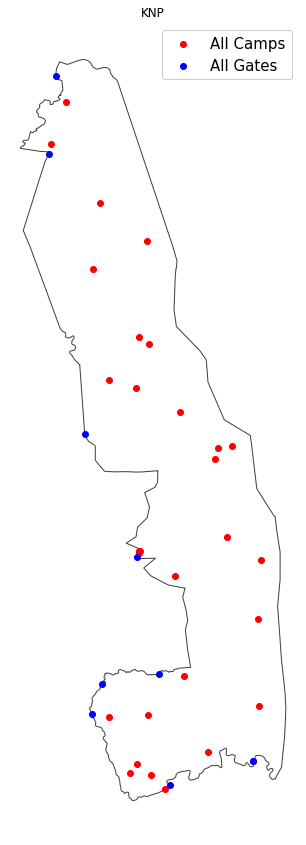

In [51]:
map_df = geopandas.read_file('knp.geojson')

fig, ax = plt.subplots(figsize = (15, 15))

ax.set(title="KNP")
map_df.plot(ax = ax, alpha = 0.75, facecolor='none', edgecolor='black')

gdf.plot(ax=ax, color='red', label="All Camps")
gates_gdf.plot(ax=ax, color='blue', label="All Gates")


ax.set_axis_off() # no axis needed in mercator?
plt.legend(framealpha=1, prop={'size':15})